# 0. 사용할 패키지 불러오기

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Activation, Lambda, InputLayer
from keras.layers.convolutional import Conv2D
from keras.layers.core import K, Dropout
from keras import optimizers
from keras.callbacks import TensorBoard

Using TensorFlow backend.


# 1. 데이터셋 생성하기

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 120, 320))
y_train = np.empty((0, 4))
training_data = glob.glob('./training_data/*.npz')

for single_npz in training_data:
    with np.load(single_npz) as data:
        x = data['train']
        y = data['train_labels']
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))

x_train=x_train.reshape(-1,120,320,1)

# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

((7413, 120, 320, 1), (7413, 4))
((3178, 120, 320, 1), (3178, 4))


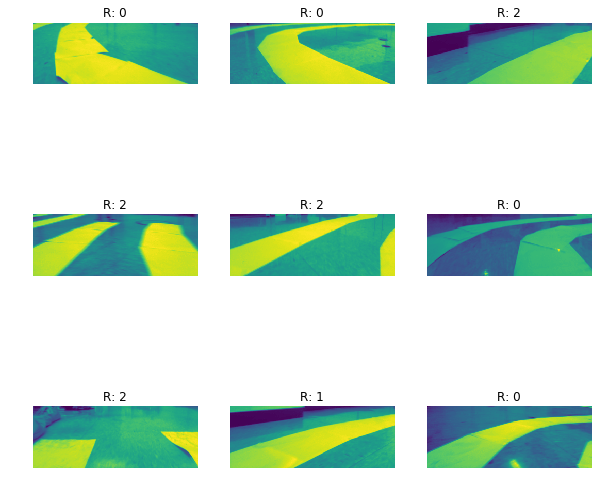

In [3]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 3
plt_col = 3

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(120, 320))
    sub_plt_title = 'R: ' + str(np.argmax(y_train[i]))
    sub_plt.set_title(sub_plt_title)

plt.show()

In [4]:
K.clear_session()

# 2. 모델 구성하기

In [5]:
gpu_usage = '/gpu:1'

In [6]:
def nvidia_net():
    with K.tf.device(gpu_usage):
        # model setting
        H = 120
        W = 320
        CH = 1
        init = 'he_normal'
        activation = 'relu'
        keep_prob = 0.5
        keep_prob_dense = 0.5
        
        model = Sequential()
        
        # pre-processing
        model.add(InputLayer(input_shape=(H, W, CH)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
    
        # Convnet
        model.add(Conv2D(24, (5, 5), padding="valid", strides=(2, 2), kernel_initializer=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        model.add(Conv2D(36, (5, 5), padding="valid", strides=(2, 2), kernel_initializer=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        model.add(Conv2D(48, (5, 5), padding="valid", strides=(2, 2), kernel_initializer=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        model.add(Conv2D(64, (3, 3), kernel_initializer=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        model.add(Conv2D(64, (3, 3), kernel_initializer=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # FC
        model.add(Flatten())

        model.add(Dense(100, kernel_initializer=init))
        model.add(Dropout(keep_prob_dense))

        model.add(Dense(50, kernel_initializer=init))
        model.add(Dropout(keep_prob_dense))

        model.add(Dense(10, kernel_initializer=init))
        model.add(Dropout(keep_prob_dense))
        
        model.add(Dense(4, kernel_initializer=init))
        model.add(Activation('softmax'))
        
        model.summary
        
        return(model)
        

model_n = nvidia_net()
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 320, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 1)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        624       
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
__________

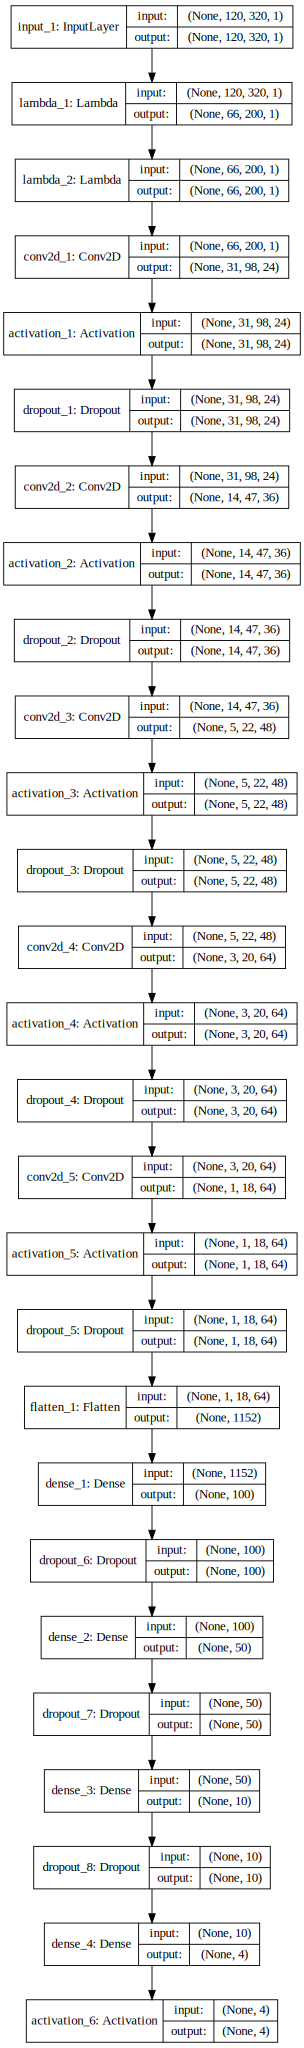

In [8]:
# 모델 확인

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_n, show_shapes=True).create(prog='dot', format='svg'))

# 3. 모델 학습과정 설정하기

In [12]:
adam = optimizers.Adam(lr=0.001, decay=0.09, amsgrad=True)
model_n.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기

In [13]:
# tensorboard 사용
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)

In [14]:
hist = model_n.fit(x_train, y_train, epochs=100, batch_size=512, validation_split=0.2, shuffle=True, callbacks=[tbCallBack])

Train on 5930 samples, validate on 1483 samples
Epoch 1/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.2196 - acc: 0.3560 - val_loss: 0.1817 - val_acc: 0.4862
Epoch 2/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1744 - acc: 0.4223 - val_loss: 0.1752 - val_acc: 0.4862
Epoch 3/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1694 - acc: 0.4447 - val_loss: 0.1671 - val_acc: 0.4862
Epoch 4/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1689 - acc: 0.4530 - val_loss: 0.1660 - val_acc: 0.4862
Epoch 5/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1665 - acc: 0.4757 - val_loss: 0.1648 - val_acc: 0.4862
Epoch 6/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1660 - acc: 0.4791 - val_loss: 0.1637 - val_acc: 0.4862
Epoch 7/100
5930/5930 [==============================] - 6s 1ms/step - loss: 0.1647 - acc: 0.4853 - val_loss: 0.1598 - val_acc: 0.4862
Epoch 8

Epoch 61/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1089 - acc: 0.6978 - val_loss: 0.1066 - val_acc: 0.6979
Epoch 62/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1072 - acc: 0.7061 - val_loss: 0.1063 - val_acc: 0.6993
Epoch 63/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1077 - acc: 0.7091 - val_loss: 0.1056 - val_acc: 0.7087
Epoch 64/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1074 - acc: 0.7000 - val_loss: 0.1056 - val_acc: 0.7087
Epoch 65/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1073 - acc: 0.7019 - val_loss: 0.1061 - val_acc: 0.7026
Epoch 66/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1054 - acc: 0.7103 - val_loss: 0.1058 - val_acc: 0.7087
Epoch 67/100
5930/5930 [==============================] - 7s 1ms/step - loss: 0.1078 - acc: 0.7039 - val_loss: 0.1059 - val_acc: 0.6966
Epoch 68/100
5930/5930 [========================

# 5. 학습과정 살펴보기

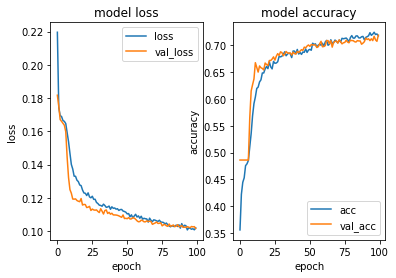

In [15]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show();

In [16]:
# 텐서보드로 학습과정 살펴보기
# 터미널에서 실행
# tensorboard --logdir ~/FreeRun/computer/Graph

# 6. 모델 평가하기

In [17]:
loss_and_metrics = model_n.evaluate(x_test, y_test, batch_size=512)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

3178/3178 [==============================] - 1s 169us/step
## evaluation loss and_metrics ##
[0.099282124752027578, 0.71428571361052007]


# 7. 모델 사용하기

In [18]:
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]

yhat_classes = model_n.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 0, Predict : 0
True : 2, Predict : 2
True : 0, Predict : 2
True : 0, Predict : 0
True : 2, Predict : 2


# 8. 모델 저장하기

In [19]:
model_json = model_n.to_json()
with open("./nvidia/nvidia_model.json", "w") as json_file:
    json_file.write(model_json)

model_n.save_weights('./nvidia/nvidia_model_weights.h5')